In [1]:
# Function to convert bounding box to polygon
import pandas as pd
import numpy as np
import pytest
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
import datasets
from datasets import Dataset
import pdb
from shapely.geometry import box



import cv2


def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string
    
def load_ac_data_spreadsheet(params):
    import pandas as pd
    data_labels = pd.read_csv(params["data_labels_path"])
    data_labels["data_labels_path"] = params["data_labels_path"]
    data_labels['images_folder'] = params["images_folder"]
    data_labels['num_ac'] = data_labels['ac_present'].str.extract(r"\(\s*(\d+)\s*\)").astype(float)
    

    # Fill NaN values with 0
    data_labels['num_ac'] = data_labels['num_ac'].fillna(0).infer_objects(copy=False)
    

    # Apply the function to the the right columns column
    for col in ['ac_present', 'ac_leaking', 'ac_discolored']:
        data_labels[col] = data_labels[col].astype(str)
        data_labels[col] = data_labels[col].apply(clean_string)
    
    data_labels['black1hot'] = data_labels['ac_discolored'].str.contains('black').astype(int)
    
    data_labels['white1hot'] = data_labels['ac_discolored'].str.contains('white').astype(int)
    
    data_labels['present1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['present_unknown1hot'] = data_labels['ac_present'].str.contains('yes').astype(int)
    
    data_labels['leaking_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    data_labels['color_unknown1hot'] = data_labels['ac_leaking'].str.contains('yes').astype(int)
    
    
    

    # Extract the numbers in brackets and convert them to integers
    assert data_labels.loc[data_labels['ac_present'] == 'yes', 'num_ac'].min() == 1
    return data_labels


def extract_label_data(label_set):
    rows = []
    for idx in range(0,len(label_set['projects'])):
        image_id = label_set['data_row'].iloc[idx]['external_id'] 
        # Iterate over each item in the data
        project_key = list(label_set['projects'][idx].keys())[0]
        for item in label_set['projects'][idx][project_key]['labels']:
            # Extract the necessary fields
            label_details = item['label_details']
            performance_details = item['performance_details']
            annotations = item['annotations']['objects']
            annotation_session_id = item['id']
        
            # Iterate over each annotation
            for annotation in annotations:
                # Create a dictionary for this row
                row = {
                    'feature_id' : annotation['feature_id'],
                    'annotation_session_id': annotation_session_id,
                    'image_id': image_id,
                    'worker': label_details['created_by'],
                    'seconds_to_create': performance_details['seconds_to_create'],
                    'annotation_kind': annotation['annotation_kind'],
                    'top': annotation['bounding_box']['top'],
                    'left': annotation['bounding_box']['left'],
                    'height': annotation['bounding_box']['height'],
                    'width': annotation['bounding_box']['width'],
                    'name': annotation['name'],
                    'value': annotation['value'],
                    
                    
                }
        
                # Append the row to the list
                rows.append(row)
        
        # Convert the list of rows into a DataFrame
        df = pd.DataFrame(rows)
    return df

def test_extract_label_data():
    # Define a sample label set
    label_set = {
        'projects': [
            {
                'project1': {
                    'labels': [
                        {
                            'label_details': {'created_by': 'worker1'},
                            'performance_details': {'seconds_to_create': 10},
                            'id': 'id1',
                            'annotations': {
                                
                                'objects': [
                                    {
                                        'feature_id': 'id1',
                                        'annotation_kind': 'kind1',
                                        'bounding_box': {'top': 0, 'left': 0, 'height': 10, 'width': 10},
                                        'name': 'name1',
                                        'value': 'value1'
                                    }
                                ]
                            }
                        }
                    ]
                }
            }
        ],
        'data_row': pd.DataFrame({'external_id': ['id1']})
    }

    # Call the function with the sample label set
    df = extract_label_data(label_set)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'feature_id': ['id1'],
        'annotation_session_id': ['id1'],
        'image_id': ['id1'],
        'worker': ['worker1'],
        'seconds_to_create': [10],
        'annotation_kind': ['kind1'],
        'top': [0],
        'left': [0],
        'height': [10],
        'width': [10],
        'name': ['name1'],
        'value': ['value1']
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(df, expected_df)

def bbox_to_polygon(row):
    left = row['left']
    top = row['top']
    right = left + row['width']
    bottom = top + row['height']
    return Polygon([(left, top), (right, top), (right, bottom), (left, bottom)])

def test_bbox_to_polygon():
    # Define a sample row
    row = {
        'left': 5,
        'top': 5,
        'width': 10,
        'height': 10
    }

    # Call the function with the sample row
    polygon = bbox_to_polygon(row)

    # Define the expected Polygon
    expected_polygon = Polygon([(5, 5), (15, 5), (15, 15), (5, 15)])

    # Assert that the returned Polygon is as expected
    assert polygon.equals(expected_polygon)

def calculate_iou(geom1, geom2):
    intersection = geom1.intersection(geom2).area
    union = geom1.union(geom2).area
    if union == 0:
        return 0  # Non-overlapping polygons
    return intersection / union

def test_calculate_iou():
    # Define two overlapping polygons
    polygon1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
    polygon2 = Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon2)

    # Assert that the IoU is as expected
    assert pytest.approx(iou, 0.01) == (1.0/7)

    # Define two non-overlapping polygons
    polygon3 = Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])

    # Calculate the IoU
    iou = calculate_iou(polygon1, polygon3)

    # Assert that the IoU is as expected
    assert iou == 0

def self_join_labels(df):
    paired_df = df[df.annotation_kind == 'ImageBoundingBox']
    paired_df = paired_df[['image_id','worker', 'geometry','name']]
    paired_df = pd.merge(paired_df.rename(columns={'worker': 'worker1', 'geometry': 'geometry1'}),
                      paired_df.rename(columns={'worker': 'worker2', 'geometry': 'geometry2'}),
                      on=['image_id','name'])
    
    # Filter to keep only pairs where worker1 < worker2
    paired_df = paired_df[paired_df['worker1'] < paired_df['worker2']].reset_index(drop=True)
    return paired_df


def test_self_join_labels():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1'],
        'worker': ['w1', 'w1', 'w2'],
        'geometry': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]), Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])],
        'name': ['n1', 'n1', 'n1'],
        'annotation_kind': ['ImageBoundingBox', 'ImageBoundingBox', 'ImageBoundingBox']
    })

    # Call the function with the sample DataFrame
    paired_df = self_join_labels(df)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'worker1': ['w1','w1'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),Polygon([(0, 0), (2, 0), (2, 2), (0, 2)])],
        'name': ['n1','n1'],
        'worker2': ['w2','w2'],
        'geometry2': [Polygon([(2, 2), (3, 2), (3, 3), (2, 3)]),Polygon([(2, 2), (3, 2), (3, 3), (2, 3)])]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(paired_df, expected_df)


# Step 2: Find the maximum IoUs for each worker-worker pair for each image_id and name
def process_matches(group):
    #Find pairs of geometries with the maximum IoU between worker1 and worker2 for each image and label_type. Only makes sense if only non-zero IoUs are passed in. These best matches are later used to find distinct sets for averaging
    results = []
    for (image_id, name, worker1, worker2), pair_group in group.groupby(['image_id', 'name', 'worker1', 'worker2']):
        used_geometries = set()
        
        while not pair_group.empty:
            # Find the maximum IoU
            max_iou_row = pair_group.loc[pair_group['iou'].idxmax()]
            
            
            results.append(max_iou_row)
            
            # Add the used geometries to the set
            used_geometries.add(max_iou_row['geometry1'])
            used_geometries.add(max_iou_row['geometry2'])
            
            # Remove rows with used geometries for this worker pair
            pair_group = pair_group[~(pair_group['geometry1'].isin(used_geometries) | 
                                      pair_group['geometry2'].isin(used_geometries))]
        #print('progress')
    return pd.DataFrame(results)

def test_process_matches():
    # Define a sample DataFrame
    df = pd.DataFrame({
        'image_id': ['id1', 'id1', 'id1', 'id1'],
        'name': ['name1', 'name1', 'name1', 'name1'],
        'worker1': ['worker1', 'worker1', 'worker1', 'worker1'],
        'worker2': ['worker2', 'worker2', 'worker2', 'worker2'],
        'geometry1': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'geometry2': [Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]), Polygon([(50, 50), (52, 50), (52, 52), (50, 52)]), Polygon([(72, 72), (73, 72), (73, 73), (72, 73)]), Polygon([(30, 30), (31, 30), (31, 31), (30, 31)])],
        'iou': [1.0/7, 0, 0, 1]
    })

    # Call the function with the sample DataFrame
    grouped = df.groupby(['image_id','name', 'worker1', 'worker2'])
    processed_df = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)

    # Define the expected DataFrame
    expected_df = pd.DataFrame({
        'image_id': ['id1','id1'],
        'name': ['name1','name1'],
        'worker1': ['worker1','worker1'],
        'worker2': ['worker2','worker2'],
        'geometry1': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])],
        'geometry2': [Polygon([(30, 30), (31, 30), (31, 31), (30, 31)]),Polygon([(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)])],
        'iou': [1,1.0/7]
    })

    # Assert that the returned DataFrame is as expected
    pd.testing.assert_frame_equal(processed_df, expected_df)

def find_sets(pairs):
    # Find connected sets of geometries
    sets = []
    for pair in pairs:
        found = False
        for s in sets:
            if pair[0] in s or pair[1] in s:
                s.add(pair[0])
                s.add(pair[1])
                found = True
                break
        if not found:
            sets.append({pair[0], pair[1]})
    return sets

def test_find_sets():
    # Define a sample list of pairs
    pairs = [(1, 2), (2, 3), (4, 5), (5, 6), (7, 8)]

    # Call the function with the sample list of pairs
    sets = find_sets(pairs)

    # Define the expected list of sets
    expected_sets = [{1, 2, 3}, {4, 5, 6}, {7, 8}]

    # Assert that the returned list of sets is as expected
    assert sets == expected_sets

def filter_matched_boxes(matched_boxes, min_matches_per_image = 3):
    # keep only the matched boxes where there are at least n matches per image, name, worker, worker geometry
    

    matched_boxes['geo_str1'] = matched_boxes['geometry1'].apply(lambda x: str(x))
    matched_boxes['geo_str2'] = matched_boxes['geometry2'].apply(lambda x: str(x))
    keeper_geometries  = pd.concat([matched_boxes[['image_id','name','worker1','geo_str1']].rename(columns={'worker1': 'worker','geo_str1': 'geo_str'}),matched_boxes[['image_id','name','worker2','geo_str2']].rename(columns={'worker2': 'worker','geo_str2': 'geo_str'})], axis = 0)
    # Find all the geometries where there are at least 3 matches for a given geometry
    keeper_size = keeper_geometries.groupby(['image_id','name','worker','geo_str']).size().rename('num_matches') + 1
    keeper_size = keeper_size[keeper_size >=(min_matches_per_image)]
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame(), left_on = ['image_id','name','worker1','geo_str1'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    matched_boxes = matched_boxes.merge(keeper_size.to_frame().drop('num_matches',axis = 1), left_on = ['image_id','name','worker2','geo_str2'], right_on = ['image_id','name','worker','geo_str'], how = 'inner')
    
    return matched_boxes


def test_filter_matched_boxes():
    #Needs implementation
    print('test_filter_matched_boxes Not implemented')
    
def average_polygon(polygons):
    # Calculate the average coordinates for each point
    avg_coords = [
        (sum(polygon.exterior.coords[i][0] for polygon in polygons) / len(polygons),
         sum(polygon.exterior.coords[i][1] for polygon in polygons) / len(polygons))
        for i in range(5)  # 5 points in the polygon
    ]
    avg_coords = np.round(avg_coords, 0)
    # Create a new polygon using the average coordinates
    avg_polygon = Polygon(avg_coords)

    return avg_polygon

def test_average_polygon():
    #Needs implementation
    print('test_average_polygon Not implemented')    
 
def do_any_sets_intersect(sets):
    # Iterate over each pair of sets
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            # If the intersection is not empty
            if sets[i] & sets[j]:
                return True
    return False

def test_do_any_sets_intersect():
    #Needs implementation
    print('test_do_any_sets_intersect Not implemented')   
    
    
def label_annotation_sets(df, connected_sets, annotators_per_image):
    #Find all of the unique annotation locations and give a set order, count the number of annotators that contributed to that set, average the annotations for each set
    df_cs = pd.merge(df, connected_sets, on = ['image_id','name'], how = 'outer')
    df_cs['connected_sets'] = df_cs.apply(lambda x: x['connected_sets'] if x['connected_sets'] is not np.nan else [{}], axis = 1)
    df_cs['is_in_set'] = df_cs.apply(lambda x: np.array([int(x['geometry'] in x['connected_sets'][cnt]) for cnt in range(len(x['connected_sets']))]), axis = 1)
    grouped = df_cs.groupby(['image_id','name'])
    set_agreement = grouped['is_in_set'].apply(lambda x: np.sum(x)).rename('num_agree_in_set').reset_index()
    set_agreement['set_order'] = set_agreement['num_agree_in_set'].apply(lambda x: list(range(len(x))))
    sa = set_agreement.explode(['set_order','num_agree_in_set']).reset_index(drop=True)
    cs = connected_sets.to_frame()
    cs['set_order'] = cs['connected_sets'].apply(lambda x: list(range(len(x))))
    cs = cs.explode(['connected_sets','set_order']).reset_index(drop=False)
    matched_sets = pd.merge(sa,cs, on = ['image_id','name','set_order'], how = 'inner')
    matched_sets = matched_sets.reset_index().rename(columns = {'index': 'roi_index'})
    matched_sets['averaged_polygons'] = matched_sets['connected_sets'].apply(lambda x: average_polygon(x))
    matched_sets['percent_agreement'] = matched_sets['num_agree_in_set']/annotators_per_image*100
    # Find image_id, annotation types where sets intersect (should be rare, find the offending labels that are causing the intersection and remove at the feature_id level
    intersecting_sets = connected_sets[connected_sets.apply(lambda x: do_any_sets_intersect(x))]
    
    for min_matches_per_image in range(1,annotators_per_image+1):
        if min_matches_per_image == 1:
            print('Number of detected objects with min agreement threshold set to ' + str(min_matches_per_image/annotators_per_image*100) + ' percent:')
            print(df.groupby('name').size()-matched_sets.groupby(['name'])['num_agree_in_set'].sum())
        else:
            filt_connected_sets = matched_sets[matched_sets['num_agree_in_set'] >= min_matches_per_image]
            print('Number of detected objects with min agreement threshold set to ' + str(min_matches_per_image/annotators_per_image*100) + ' percent:')
            filt_connected_sets.groupby('name').size()
            print(filt_connected_sets.groupby('name').size())
    
    print('Number of intersecting sets: ' + str(len(intersecting_sets)))
    print('First average polygon :' + str(average_polygon(connected_sets.iloc[0][0])))
    return matched_sets
    
def mask_images_by_box(params):
    import cv2
    import os
    import numpy as np
    os.makedirs(params["images_folder"]+'_bounding_boxes', exist_ok=True)
    kernal_size = 24
    # Set default values for parameters if they are not provided
    if 'image_ids' not in params:
        data_labels = load_ac_data_labels(params)
        params["image_ids"] = data_labels["image_id"]
    if 'hsv_range' not in params:
        params['hsv_range'] = [[8, 120, 200], [12, 255, 255]]
    if 'kernal' not in params:
        params['kernal'] = np.ones((kernal_size,kernal_size), np.uint8)
    if 'min_bb_area' not in params:
        params['min_bb_area'] = 1
    if 'max_bb_area' not in params:
        params['max_bb_area'] = 1000000000
    if 'min_ratio' not in params:
        params['min_ratio'] = 1.0
    image_df = pd.DataFrame(columns= ['image_id', 'image_path','x', 'y', 'w', 'h'])
    for image_id in params['image_ids']:  
        image_path = os.path.join(params['images_folder'], image_id)
        #pdb.set_trace()
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find the orange bounding box in the image
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if params['hsv_range'] is not None:
            lower_orange = np.array(params['hsv_range'][0])
            upper_orange = np.array(params['hsv_range'][1])
            mask = cv2.inRange(hsv, lower_orange, upper_orange)
        else:
            mask = cv2.inRange(hsv, np.array([0,0,0]),np.array([180,255,255])) #no filter
    
        
        # Perform dilation on the mask to close small gaps
        if params['kernal'] is not None:
            kernel = params['kernal']
            mask = cv2.dilate(mask, kernel, iterations=2)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(np.size(image))
        # Function to find the contour with the highest perimeter-to-area ratio
        def find_hollow_box(contours, mask, params):
            hollow_contours = []
            for contour in contours:
                # Get the bounding rectangle of the largest rectangular contour
                x, y, w, h = cv2.boundingRect(contour)
                # Crop the mask around the bounding rectangle, accounting for kernal size
                cropped_mask = mask[y:y+h, x:x+w]
                mask_area = cv2.countNonZero(cropped_mask)
                bb_area = w*h
    
                if mask_area > 0:
                    ratio = bb_area / mask_area
                    if ratio > params['min_ratio'] and bb_area > params['min_bb_area'] and bb_area < params['max_bb_area']:
                        hollow_contours.append(contour)
                        #print('ratio:' + str(ratio) + ' bb_area:' + str(bb_area) + ' mask_area:' + str(mask_area) + ' of image ' + image_id)
                         
            return hollow_contours  
        # Find the contour that best matches a hollow box
        contours = find_hollow_box(contours, mask, params)
        if contours == []:
            print(f'No bounding box found for image {image_id}')
            continue
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': 0, 'y': 0, 'w': 0, 'h': 0}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
        else:
            # Find the largest rectangular contour
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the bounding rectangle of the largest rectangular contour
            x, y, w, h = cv2.boundingRect(largest_contour)
            # Crop the image around the bounding rectangle
            #cropped_image = image[y:y+h, x:x+w]
            kshift = int(kernal_size) +10
            x = x + kshift
            if x < 0:
                x = 0
            y = y + kshift
            if y < 0:
                y = 0
            w = w - kshift*2
            if w < 0:
                w = 0
            h = h - kshift*2
            if h < 0:
                h = 0
            cropped_image = mask[y:y+h, x:x+w]
            tmp = pd.DataFrame({'image_id': image_id, 'image_path': image_path, 'x': x, 'y': y, 'w': w, 'h': h}, index = [0])
            image_df = pd.concat([image_df, tmp], axis = 0, ignore_index=True)
            

            
    return image_df 

def generate_matched_sets(df, iou_threshold, annotators_per_image):

    df['geometry'] = df.apply(bbox_to_polygon, axis=1)
    paired_df = self_join_labels(df)
    paired_df['iou'] = paired_df.apply(lambda row: calculate_iou(row['geometry1'], row['geometry2']), axis=1)
    paired_df = paired_df[['image_id', 'name','worker1', 'worker2', 'geometry1', 'geometry2', 'iou']]
    paired_df = paired_df[paired_df['iou'] > iou_threshold]
    
    grouped = paired_df.groupby(['image_id','name', 'worker1', 'worker2'])
    matched_boxes = grouped[['image_id','name', 'worker1', 'worker2','geometry1','geometry2','iou']].apply(process_matches).reset_index(drop=True)
    
    grouped = matched_boxes.groupby(['image_id','name'])
    connected_sets = (grouped[['image_id', 'name', 'worker1', 'worker2', 'geometry1','geometry2', 'iou']].apply(lambda x: find_sets(list(zip(x['geometry1'],x['geometry2'])))).rename('connected_sets'))
    
    
    matched_sets = label_annotation_sets(df, connected_sets, annotators_per_image)
    return matched_sets

def spot_check_annotations(full_train, image_idx = 320, min_agreement = 80, zoom = False):
    patch_df = (full_train[(full_train['image_id'] == full_train['image_id'].iloc[image_idx])
                          & (full_train['percent_agreement'] >= min_agreement)])
    category = np.array(patch_df['name'])
    mask_geometry = patch_df['mask_geometry'].iloc[0]
    category_polygons = patch_df['averaged_polygons']
    image_path = patch_df['image_path'].iloc[0]
    display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom = zoom)

def convert_polygon_to_bbox(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    return minx, miny, width, height


def display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom=False):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(image)
    

    if isinstance(category_polygons, Polygon):
        category_polygons= [category_polygons]


    if not zoom: # Display the mask
        x, y, width, height = convert_polygon_to_bbox(mask_geometry)
        patch = patches.Rectangle((x,y),width,height, edgecolor='green', facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    # Display the averaged polygons
    for cnt,polygon in enumerate(category_polygons):
        x, y, width, height = convert_polygon_to_bbox(polygon)
        if category[cnt] == 'AC Unit':
            color = 'green'
        elif category[cnt] == 'AC leaking':
            color = 'red'
        else:
            ValueError('Category not recognized')
            
        patch = patches.Rectangle((x,y),width,height, edgecolor=color, facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    if zoom:
        # Set the limits of the plot to the extent of the mask
        minx, miny, maxx, maxy = mask_geometry.bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.grid(False)
    # Show the plot
    plt.show()


def crop_image(image_path, bbox):
    import PIL
    image = PIL.Image.open(image_path)
    cropped_image = image.crop(bbox)
    return cropped_image

def adjust_bboxes_from_crop(mask_bbox, category_bbox):
    category_bbox = (category_bbox[0] - mask_bbox[0], category_bbox[1] - mask_bbox[1], category_bbox[2], category_bbox[3])
    return category_bbox


def load_cropped_images_and_adjust_bboxes(df,mask_patch):
    
    mask_bbox = ([int(mask_patch['x'].iloc[0]), 
             int(mask_patch['y'].iloc[0]), 
             int(mask_patch['w'].iloc[0]), 
             int(mask_patch['h'].iloc[0])])
    image_id = mask_patch['image_id'].iloc[0]
    image = PIL.Image.open(mask_patch['image_path'].iloc[0])
    mask_bbox = (mask_bbox[0], mask_bbox[1], mask_bbox[0] + mask_bbox[2], mask_bbox[1] + mask_bbox[3])
    image = image.crop(mask_bbox)
    #convert to rgb
    image = image.convert('RGB')
    
    #get image size
    width, height = image.size

    #image = datasets.Image(image,decode=True)
    
    bb_area = []
    bboxes = []
    ids = []
    categories = [] 
    category_ind = {'AC Unit':0, 'AC leaking':1}
    if not df.empty:
        for idx, row in df.iterrows():
            category_bbox = row['category_bbox']
            cropped_bbox = adjust_bboxes_from_crop(mask_bbox, category_bbox)
            cropped_area = (cropped_bbox[2] - cropped_bbox[0]) * (cropped_bbox[3] - cropped_bbox[1])
            bb_area.append(cropped_area)
            bboxes.append(cropped_bbox)
        ids = [x for x in df['roi_index']]
        categories = [category_ind[x] for x in df['name']]
    
    
    json_data =({
    'image_id': image_id,
    'image': image,
    'width': width,
    'height': height,
    'objects': {
        'id': ids,
        'area': [int(x) for x in bb_area],
        'bbox': bboxes,
        'category': categories
        }
    })

    return json_data

def generate_hf_ds(full_train, mask_df, params):
    hf_ds = []
    # Crop the images based on the mask and adjust all of the bounding boxes to match the cropped image. load and edit the images using PIL
    for image_id in mask_df.image_id.unique():
        patch_df = (full_train[(full_train['image_id'] == image_id)
                          & (full_train['percent_agreement'] >= 80)])
        mask_patch = mask_df[mask_df['image_id'] == image_id]
    
        json_data = load_cropped_images_and_adjust_bboxes(patch_df,mask_patch)
        hf_ds.append(json_data)
    len(hf_ds)
    
    import os
    params['cropped_images_folder'] = params['images_folder'] +  "_cropped_" + params['dataset_version'] 
    os.makedirs(params['cropped_images_folder'], exist_ok=True)
    for i in range(len(hf_ds)):
        image = hf_ds[i]['image']
        cropped_path = os.path.join(params['cropped_images_folder'], hf_ds[i]['image_id'])
        image.save(cropped_path)
        hf_ds[i]['image'] = cropped_path
        hf_ds[i]['image_id'] = i
    
    
    features = datasets.Features({'image_id': datasets.Value(dtype='int64', id=None),
     'image': datasets.Image(mode=None, decode=True, id=None),
     'width': datasets.Value(dtype='int32', id=None),
     'height': datasets.Value(dtype='int32', id=None),
     'objects': datasets.Sequence(feature={'id': datasets.Value(dtype='int64', id=None), 'area': datasets.Value(dtype='int64', id=None), 'bbox': datasets.Sequence(feature=datasets.Value(dtype='float32', id=None), length=4, id=None), 'category': datasets.ClassLabel(names=['AC Unit','AC leaking'], id=None)}, length=-1, id=None)})
    
    ds = Dataset.from_pandas(pd.DataFrame(hf_ds),features=features).cast_column('image', datasets.Image())
    ds.save_to_disk("../data/models/ac_model/ac_object_" + params['dataset_version'] + ".hf")
    return ds

test_calculate_iou()
test_extract_label_data()
test_self_join_labels()
test_bbox_to_polygon()
test_process_matches()
test_find_sets()
test_filter_matched_boxes()
test_average_polygon()
test_do_any_sets_intersect()

test_filter_matched_boxes Not implemented
test_average_polygon Not implemented
test_do_any_sets_intersect Not implemented


In [19]:
#%load_ext memray
# Load in the data labels
params = {}
#params['category_index_column'] = "present1hot"
params['category_labels'] = ['No', 'Yes']
params['images_folder'] = '../data/images/ac_150_images'
params["data_labels_path"] = '../data/labels/ac_150_labels_jess_notes.csv'
params["annotation_path"] = '../data/labels/Export v2 project - AC Unit Evaluation Test - 7_3_2024.ndjson'
params["iou_threshold"] = 1.0/3
params["annotators_per_image"] = 5
# params['kernal'] = np.ones((12,12), np.uint8)
# params['hsv_range'] = [[8, 120, 200], [12, 255, 255]]
# params['min_ratio'] = 2
params['dataset_version'] = 'v4'
params['rerun_ds_generation'] = True

prime_labels = load_ac_data_spreadsheet(params)
prime_labels = prime_labels.rename(columns = {'row_number ': 'row_number'})
label_set = pd.read_json(params["annotation_path"], lines=True)
df = extract_label_data(label_set)
#join prime_labels row_number to df with image_id
df = pd.merge(df, prime_labels[['image_id','row_number']], on = 'image_id', how = 'inner')
df = df.rename(columns = {'row_number': 'image_orig_idx'})

#remove intersecting bounding box (specific to ../data/images/ac_150)
df = df[df['feature_id'] != 'clxgcq78i00hx3b6qit987ryb']

matched_sets = generate_matched_sets(df, params["iou_threshold"], params["annotators_per_image"])

params["image_ids"] = prime_labels['image_id']
mask_df = mask_images_by_box(params)

#fix bounding boxes (specific to ../data/images/ac_150)
mask_df.loc[mask_df['image_id'] == 'EC33B284-5C10-4EDA-AD17-5571259F97CA.jpeg',['x','y','w','h']] = [480,250,450,550]
mask_df.loc[mask_df['image_id'] == '0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg',['x','y','w','h']] = [730,375,218,390]

# turn columns x,y,w,h in shapely polygons
mask_df['mask_geometry'] = mask_df.apply(lambda row: box(row['x'], row['y'], row['x']+row['w'], row['y']+row['h']), axis=1)
mask_df['mask_geometry'] = mask_df['mask_geometry'].apply(lambda x: Polygon(x.exterior.coords))

full_train = pd.merge(matched_sets, mask_df, on = 'image_id', how = 'outer')
no_annotation_rows = full_train.loc[full_train['roi_index'].isna(),:]

no_annotation_rows.loc[no_annotation_rows['roi_index'].isna(),['roi_index','name','num_agree_in_set','set_order','connected_sets','averaged_polygons','percent_agreement']] = [-1,'AC Unit',5,0,{},Polygon([(0,0),(0,0),(0,0),(0,0),(0,0)]),100]

no_annotation_rows2 = no_annotation_rows.copy(deep = True)
no_annotation_rows2['name'] = 'AC leaking'

full_train = pd.concat([full_train.dropna(subset = ['roi_index']), no_annotation_rows, no_annotation_rows2], axis = 0, ignore_index = True)


# full_train.loc[full_train['roi_index'] != -1,'has_roi'] = 1
# full_train.loc[full_train['roi_index'] == -1,'has_roi'] = 0

full_train['mask_bbox'] = full_train['mask_geometry'].apply(lambda x: convert_polygon_to_bbox(x))
full_train['category_bbox'] = full_train['averaged_polygons'].apply(lambda x: convert_polygon_to_bbox(x))


if params['rerun_ds_generation']:
    ds = generate_hf_ds(full_train.dropna(subset = ['roi_index']), mask_df, params)
else:
    print('Dataset generation skipped')
    print('Loading previously generated dataset')
    ds = datasets.load_from_disk("../data/models/ac_model/ac_object_" + params['dataset_version'] + ".hf")

     

Number of detected objects with min agreement threshold set to 20.0 percent:
name
AC Unit       25
AC leaking    53
dtype: object
Number of detected objects with min agreement threshold set to 40.0 percent:
name
AC Unit       292
AC leaking     94
dtype: int64
Number of detected objects with min agreement threshold set to 60.0 percent:
name
AC Unit       275
AC leaking     72
dtype: int64
Number of detected objects with min agreement threshold set to 80.0 percent:
name
AC Unit       266
AC leaking     63
dtype: int64
Number of detected objects with min agreement threshold set to 100.0 percent:
name
AC Unit       242
AC leaking     41
dtype: int64
Number of intersecting sets: 0
First average polygon :POLYGON ((843 577, 867 577, 867 613, 843 613, 843 577))


Saving the dataset (0/1 shards):   0%|          | 0/150 [00:00<?, ? examples/s]

NameError: name 's' is not defined

In [22]:
prime_labels = load_ac_data_spreadsheet(params)

In [12]:
prime_labels = prime_labels.reset_index()
[['image_id','row_number']]

KeyError: "['row_number'] not in index"

In [34]:
print(prime_labels[prime_labels['ac_leaking'] == 'yes'].index.to_list())

[0, 6, 8, 10, 12, 13, 18, 25, 29, 39, 42, 43, 45, 47, 51, 56, 61, 65, 66, 68, 70, 71, 72, 75, 76, 77, 79, 83, 87, 93, 98, 110, 111, 114, 121, 125, 128, 130, 143, 147, 149]


In [204]:
# EC33B284-5C10-4EDA-AD17-5571259F97CA_cropped.jpeg is a bad crop
# 0AD2D165-CE95-4F5C-BF88-524EA08A686E_cropped.jpeg is a bad crop

In [33]:
prime_labels[prime_labels['image_id'].str.contains('C9486')]

,row_number,image_id,address,ac_present,ac_leaking,ac_discolored,comments,jess_notes,data_labels_path,images_folder,num_ac,black1hot,white1hot,present1hot,leaking1hot,present_unknown1hot,leaking_unknown1hot,color_unknown1hot
106,107,C9486E14-8528-4860-93A6-B5E58EEA5533.jpeg,"2109 Stewart Ave, Las Vegas, NV 89101, USA",yes,no,no,NaN,NaN,../data/labels/ac_150_labels_jess_notes.csv,../data/images/ac_150_images,4.0,0,0,1,0,1,0,0


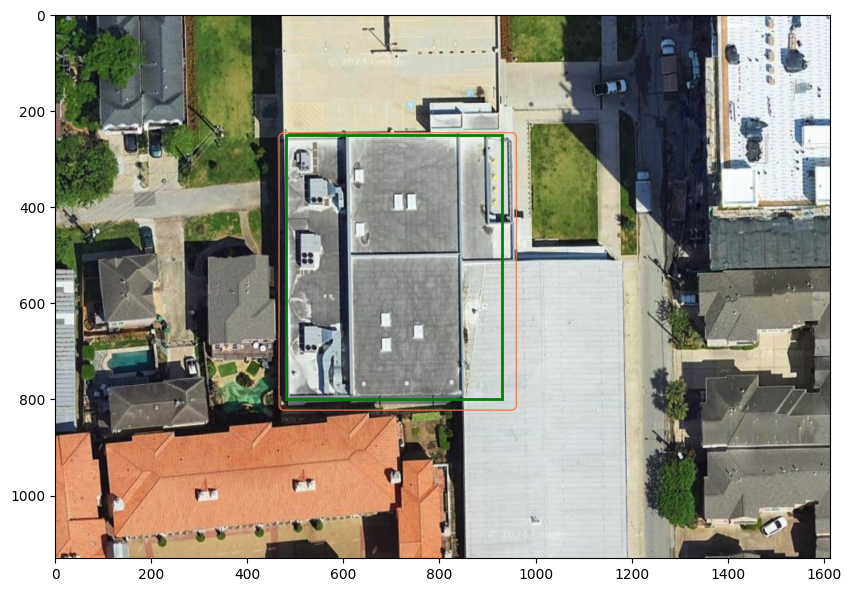

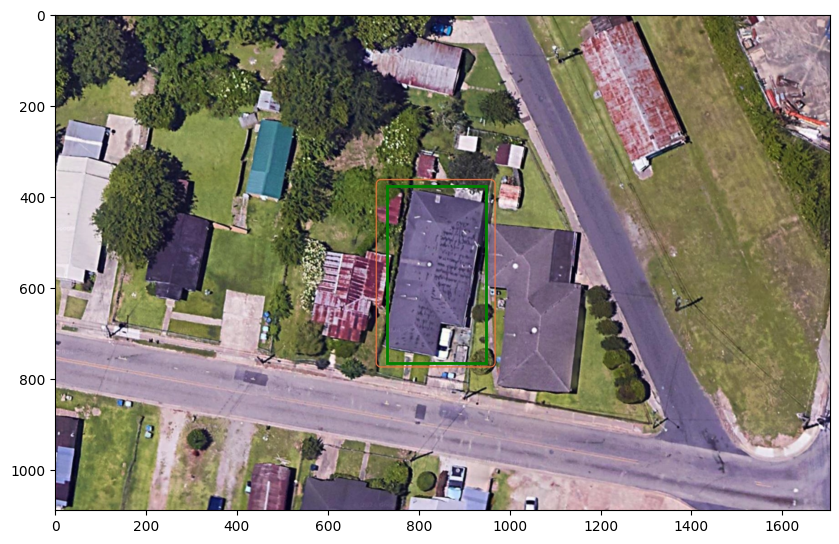

In [215]:
image_ids = ['EC33B284-5C10-4EDA-AD17-5571259F97CA.jpeg','0AD2D165-CE95-4F5C-BF88-524EA08A686E.jpeg']

for image_id in image_ids:
    patch_df = full_train[(full_train["image_id"] == image_id)].reset_index(drop=True)
    category = []
    mask_geometry = patch_df['mask_geometry'].iloc[0]
    category_polygons = []
    image_path = patch_df['image_path'].iloc[0]
    display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom = False)

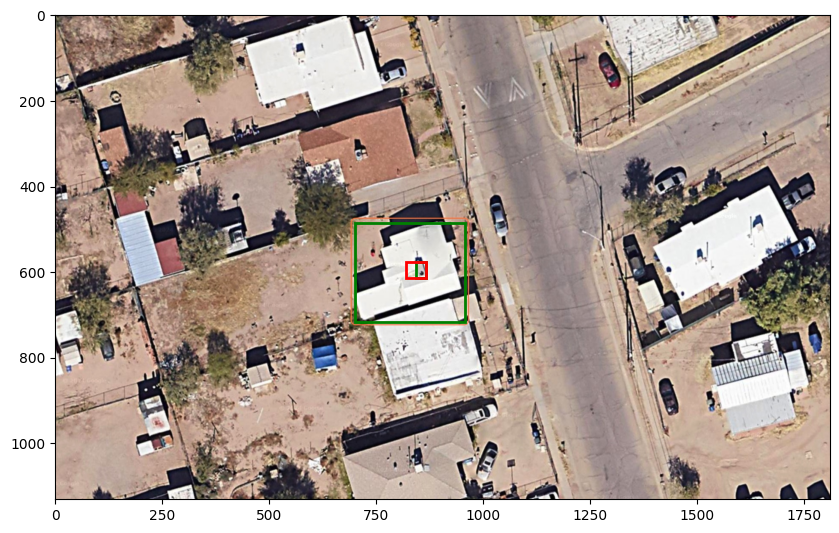

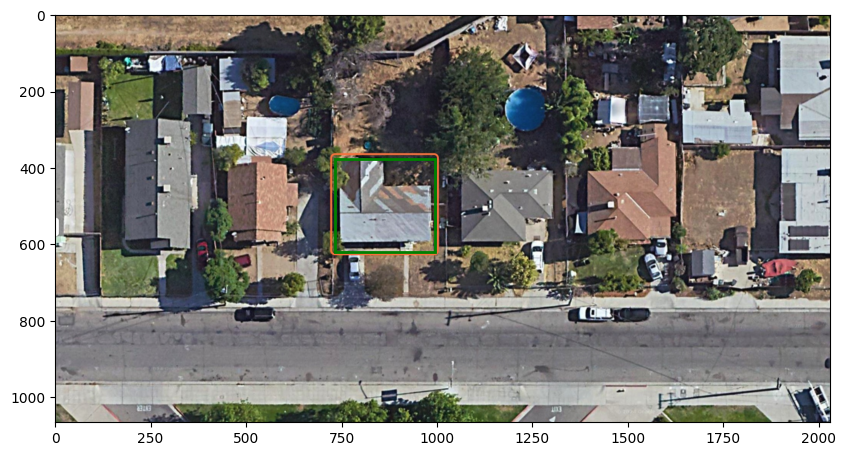

In [222]:
spot_check_annotations(full_train, 0, 80, False)
spot_check_annotations(full_train, 404, 80, False)
